In [73]:
import networkx as nx
import collections 
import numpy as np
from scipy.stats import cauchy
from sklearn.isotonic import IsotonicRegression  
import matplotlib
import matplotlib.pyplot as plt
import cvxpy as cp

In [111]:
#utility functions
def getSortedDegSeq(G):
    degSeq = sorted([d for n, d in G.degree()], reverse=False) #small to large degrees
    return degSeq

def getDegHis(G,maxDeg):
    degSeq = getSortedDegSeq(G)
    degreeCount = collections.Counter(degSeq)
    degHis = np.zeros(maxDeg+1)
    for deg in degreeCount:
        degHis[deg]=degreeCount[deg]    
    return degHis

def degSeqToDegHis(degSeq, maxDeg):
    #assume deg sequence could be non-integer and be bigger than maxDegree
    degHis = np.zeros(maxDeg+1)
    for deg in degSeq:
        #print(deg)
        deg = int(round(deg))
        if deg <= maxDeg:
            degHis[deg]= degHis[deg]+1
    return degHis
    
    
def pdfToCdf(pdf):
    cdf = np.zeros(len(pdf))
    cdf[0] = pdf[0]
    for i in range(1,len(pdf)):
         cdf[i] = cdf[i-1] + pdf[i]            
    return cdf

def cdfToPdf(cdf):
    pdf = np.zeros(len(cdf))
    pdf[0] = cdf[0]
    for i in range(1,len(pdf)):
         pdf[i] = cdf[i] - cdf[i-1]            
    return pdf
    

def difDegHis_L1(his1,his2):
    #assume the same length
    return sum(abs(his1 - his2))

def difDegHis_L2(his1,his2):
    return sum(np.square(his1-his2))



def plotHis(trueHis,noisyHis):
    plt.plot(trueHis,'-g', label='trueHis')
    plt.plot(noisyHis,'--r', label='noisyHis')
    plt.legend();
    plt.xscale('log')

    
    
def plotCum(trueHis,noisyHis):
    plt.plot(pdfToCdf(trueHis), '3b', label='trueCum')
    plt.plot(pdfToCdf(noisyHis), '2y', label='noisyCum')
    plt.legend();
    plt.xscale('log')

#DP basic functions
def lap(trueCounts, sens, epsilon):
    scale = 1.0* sens/epsilon
    noisyCounts = trueCounts + np.random.laplace(0.0, scale, len(trueCounts))
    return noisyCounts

def postprocessCdf(noisyCdf, totalCount):
    #apply isotonic regression
    ir = IsotonicRegression(y_min=0, y_max=totalCount, increasing=True)
    cdf= ir.fit_transform(X=range(len(noisyCdf)),y=noisyCdf)   
    return cdf

def postprocessPdf(noisyPdf, nodesNum):
    cdf = pdfToCdf(noisyPdf)
    cdf = postprocessCdf(cdf, nodesNum)
    pdf = cdfToPdf(cdf)
    return pdf


def extendHis(his,maxDeg):
    #his has a shortern length 
    if (maxDeg+1) > len(his):
        hisExtended = np.zeros(maxDeg + 1)
        hisExtended[0:len(his)] = his
        return hisExtended
    else:
        return his


In [110]:
#Edge DP algorithms for degree distribution

#Hay et al. ICDM'09 (baseline)
def edgeDP_degHis_Lap(G, maxDeg, epsilon):
    degHis = getDegHis(G, maxDeg)
    sens = 4.0
    noisyDegHis = lap(degHis, sens, epsilon)
    noisyDegHis = postprocessPdf(noisyDegHis, len(G.nodes()))
    return noisyDegHis


#Hay et al. ICDM'09, Proserpio et al. WOSN'12 (wPINQ)
def edgeDP_degSeq_Lap(G, maxDeg, epsilon):
    degSeq = np.array(getSortedDegSeq(G))
    sens = 2.0
    #print(degSeq)
    noisyDegSeq = lap(degSeq, sens,epsilon)
    noisyDegSeq = postprocessCdf(noisyDegSeq, maxDeg)
    #print(noisyDegSeq)
    noisyDegHis = degSeqToDegHis(noisyDegSeq, maxDeg)
    return noisyDegHis


In [105]:
#Node DP algorithms for degree distribution
################
def learnTheta(G, maxDeg, epsilon_theta, thetaList):
    #TODO: exponential mechanisms/SVT, need score functions   
    return maxDeg 


def flowgraphApprox(G,theta):
    #TODO: more efficient approximation algorithmm, but sensitivity will increase
    degSeq = []
    return degSeq

def flowgraph(G, theta):
    #https://www.cvxpy.org/examples/basic/quadratic_program.html
    #Raskhodnikova & Smith, Arxiv'15
    #Note: this algo is slow, take more than 1 min for nodeNum=200

    nodesNum = len(G.nodes()) 
    edgesNum = len(G.edges())
    print(nodesNum,edgesNum)

    nn = nodesNum * 2
    ne = edgesNum * 2
    n = nn + ne

    P = np.zeros([n,n])
    P[:(nn),:(nn)] = np.identity(nn)

    q = np.zeros(n)
    q[:(nn)] = -2.0* theta

    T = np.identity(n)
    h = np.zeros(n)+1
    h[:nn] = theta 

    #print(T,h)

    A = np.zeros([nn,n])
    edgeCount = nn
    for i in range(nodesNum):
        A[i,i] = 1 
        A[nodesNum+i,nodesNum+i] = 1
        neighborSize = len([k for k in G.neighbors(i)])
        for j in range(neighborSize):
            A[i,(edgeCount+j)] = -1
            A[nodesNum+i,(edgeCount+j)] = -1
        edgeCount = edgeCount + neighborSize
    #print(A)

    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(cp.quad_form(x,P)+ q.T @ x), [T @x <=h, x>=0, A@x == 0 ])
    prob.solve()
    #print("\nThe optimal value is", prob.value)
    #print("A solution x is")

    degList = []
    for i in range(nodesNum):
        degList.append(int(x.value[i,0].round()))
    degSeq = sorted(degList,reverse=False)
    #print(degSeq)
    return degSeq

################
#Naive laplace mechanism with postprocessing
def nodeDP_degHis_Lap(G, maxDeg, epsilon):
    degHis = getDegHis(G,maxDeg)
    sens = 2.0 * (maxDeg + 1)
    noisyDegHis = lap(degHis, sens, epsilon)
    noisyDegHis = postprocessPdf(noisyDegHis, len(G.nodes()))
    return noisyDegHis

#Adapting Hay et al. ICDM'09, Proserpio et al. WOSN'12 (wPINQ)
def nodeDP_degSeq_Lap(G, maxDeg, epsilon):
    degSeq = np.array(getSortedDegSeq(G))
    sens = 1.0* (maxDeg + 1)
    #print(degSeq)
    noisyDegSeq = lap(degSeq, sens,epsilon)
    noisyDegSeq = postprocessCdf(noisyDegSeq, len(G.nodes()))
    #print(noisyDegSeq)
    noisyDegHis = degSeqToDegHis(noisyDegSeq, maxDeg)
    #print(noisyDegHis)
    return noisyDegHis

#Shiva et al. TCC'13
def nodeDP_nodeTrun_Smooth(G, maxDeg, epsilon, thetaList):
    epsilon_deg = epsilon 
    theta = thetaList[0]
    
    #Learning theta (TCC DOES NOT HAVE THIS STEP)
    if len(thetaList) >1: #many choices 
        epsilon_theta = epsilon/2.0 
        theta = learnTheta(G, maxDeg, epsilon_theta, thetaSet)
        epsilon_deg = epsilon-epsilon_theta
    
    
    #node truncation: remove nodes with degree > theta 
    Gt = G.copy()
    nodesTrun = [n for n,d in Gt.degree() if d > theta]
    Gt.remove_nodes_from(nodesTrun)

    #smooth bound: (Prop 6.1, Algo 3)
    nodesNum = len(G.nodes())
    beta = epsilon/(np.sqrt(2.0)*(theta+1))  
    r = np.log(1.0*nodesNum/beta)
    l = len([n for n,d in Gt.degree() if (d >= theta-r and d<=theta+r)])
    smoothSens = l+1.0/beta + 1
    #print(beta, r, l,smoothSens)
    
    #add cauchy noise with epsilon_deg
    scale = 2*np.sqrt(2.0)*theta/epsilon_deg*smoothSens
    trueHisGt = getDegHis(Gt, theta)
    noisyHisGt = trueHisGt + cauchy.rvs(0,scale=smoothSens,size=len(trueHisGt))
    noisyHisG = extendHis(noisyHisGt, maxDeg)
    
    #postprocess (TCC DOES NOT HAVE THIS STEP)
    noisyHisG = postprocessPdf(noisyHisG, len(G.nodes()))
    
    return noisyHisG


#Raskhodnikova & Smith, Arxiv'15
def nodeDP_flowgraph_degSeq_Lap(G, maxDeg, epsilon, thetaList):
    epsilon_deg = epsilon 
    theta = thetaList[0]
    
    #Flowgraph algorithm to obtain a degree sequence with max degree is bounded by theta
    degSeq = flowgraph(G,theta) #getSortedDegSeq(G) #TODO: replace this line with flowgraph algorithm 
    
    #Convert degSeq to degHis and add noise (this step can be improved by learn noisy seq first)
    sens = 6.0 *theta  #Algo 1: this requires an exact solver for the flowgraph; if an approximation algorithm is used, then the sensitivity needs go up.
    degHis = degSeqToDegHis(degSeq, theta)
    noisyDegHis = lap(degHis, sens, epsilon_deg)
    
    noisyHisG = extendHis(noisyDegHis, maxDeg)
    
    #postprocess (THE PAPER DOES NOT HAVE THIS STEP)
    noisyHisG = postprocessPdf(noisyHisG, len(G.nodes()))
    
    return noisyHisG


#Day et al. SIGMOD'16
def nodeDP_edgeAdd_degHisPart_Lap(G, maxDeg, epsilon, thetaList, paritionList):
    ##TODO: incomplete (exponential mechanism to get a partition first, and then apply Lap)
    return 0


#Day et al. SIGMOD'16
def nodeDP_edgeAdd_degCum_Lap(G, maxDeg, epsilon, thetaList):
    theta = thetaList[0]
    
    #Learning theta 
    if len(thetaList) >1: #many choices 
        epsilon_theta = epsilon/2.0 
        theta = learnTheta(G, maxDeg, epsilon_theta, thetaSet)
        epsilon_deg = epsilon-epsilon_theta
    

    #Edge addition algorithm from empty graph till no edges can be added keep degree bounded by theta
    #Gt = nx.Graph()
    nodesNum = len(G.nodes())
    nodes = np.random.permutation(nodesNum)
    #Gt.add_nodes_from(nodes)
    degSeqGt = np.zeros(nodesNum)
    
    for v in nodes:
        for u in G.neighbors(v):
            if u<v and degSeqGt[u]<theta and degSeqGt[v]<theta:
                #Gt.add_edge(u,v)
                degSeqGt[u] = degSeqGt[u]+1
                degSeqGt[v] = degSeqGt[v]+1
    
    #cumulative historm + lap noise
    degHis = degSeqToDegHis(degSeqGt, theta)
    degCum = pdfToCdf(degHis)
    #print(degCum[0:30]) ###TODO: SOMETHING incorrect: many nodes have counts cutting at theta, need to be smooth out..
    
    sens = theta + 1 
    noisyDegCum = lap(degCum, sens, epsilon)
    
    #print(noisyDegCum[0:30])
    noisyDegCum = postprocessCdf(noisyDegCum, nodesNum)
    #print(noisyDegCum[0:30])
    
    noisyDegHis = cdfToPdf(noisyDegCum)
    noisyDegHis = extendHis(noisyDegHis, maxDeg) #TODO: can be better
    
    return noisyDegHis
    

    
    
    
    
                   

In [115]:
#Caller 

dataDir ="Datasets/"
datafile = dataDir+"facebook_combined.txt"
G=nx.read_edgelist(datafile, nodetype=int)
#G = nx.fast_gnp_random_graph(100,0.2)

nodesNum = len(G.nodes()) #assume this is given 
maxDeg = nodesNum -1  #assume this is given 

trueHis = getDegHis(G,maxDeg)

[  0.  75.  98.  93.  99.  93.  98.  98. 111. 100.  95.  81.  82.  79.
  87. 106.  82.  76.  73.  72.  63.  52.  63.  53.  60.  55.  56.  49.
  37.  38.]
[  0.35309049  73.4599806  101.52826974  91.83228598 100.50243629
  90.86335203  99.70474906  95.56040278 114.79261202  97.99123731
  93.83050522  78.96473155  85.92437075  75.98056975  90.67047178
 103.38017695  79.96528283  76.84605174  73.84702014  72.30474627
  60.80761329  55.73524401  61.10318917  53.80178342  59.28944075
  52.77640896  56.49853461  50.39503084  38.09214268  35.26794785]
0.09322968486869358
1.0000000000000004
376.55469718465304
4039.0


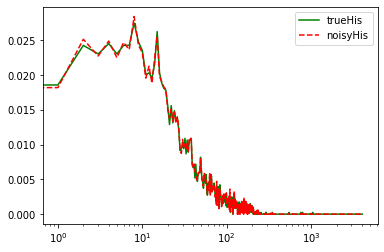

In [120]:
##Testing of algorithms for degree distribution
epsilon = 1000.0
#noisyDegHis = nodeDP_nodeTrun_Smooth(G,maxDeg,epsilon,[99])
#noisyDegHis = nodeDP_flowgraph_degSeq_Lap(G,maxDeg,epsilon,[80]) #works for small graph
#noisyDegHis = nodeDP_edgeAdd_degHisPart_Lap(G, maxDeg, epsilon, thetaList, paritionList) #INCOMPLETE
noisyDegHis = nodeDP_edgeAdd_degCum_Lap(G,maxDeg,epsilon,[1000])


print(trueHis[0:30])
print(noisyDegHis[0:30])
plotHis(trueHis/nodesNum,noisyDegHis/nodesNum)
print(difDegHis_L1(trueHis/nodesNum, noisyDegHis/nodesNum))
print(difDegHis_L1(trueHis/nodesNum, (np.zeros(maxDeg+1))/nodesNum))
print(difDegHis_L1(trueHis, noisyDegHis))
print(difDegHis_L1(trueHis, (np.zeros(maxDeg+1))))

In [118]:
###Evaluation of algorithms for degree distribution

algoNames = ["edgeDP_degHis_Lap", "edgeDP_degSeq_Lap", 
             "nodeDP_degHis_Lap", "nodeDP_degSeq_Lap", "nodeDP_nodeTrun_Smooth", 
             "nodeDP_flowgraph_degSeq_Lap", "nodeDP_edgeAdd_degHisPart_Lap", "nodeDP_edgeAdd_degCum_Lap"]
algoKey = 4
algo = algoNames[algoKey]
print(algo)

#epsList = [0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0,5.0,10.0]
epsList = [0.01, 0.1, 1.0, 10.0]
#epsList = [10]
repeats = 10

for epsilon in epsList:
    errors = []
    for i in range(repeats):
        noisyDegHis = np.zeros(maxDeg+1)
        if algo == "edgeDP_degHis_Lap":        
            noisyDegHis = edgeDP_degHis_Lap(G,maxDeg,epsilon)
        elif algo == "edgeDP_degSeq_Lap":
            noisyDegHis = edgeDP_degSeq_Lap(G,maxDeg,epsilon)
        elif algo == "nodeDP_degHis_Lap":
            noisyDegHis = nodeDP_degHis_Lap(G,maxDeg,epsilon)
        elif algo == "nodeDP_degSeq_Lap":
            noisyDegHis = nodeDP_degSeq_Lap(G,maxDeg,epsilon)
        elif algo == "nodeDP_nodeTrun_Smooth":
            noisyDegHis = nodeDP_nodeTrun_Smooth(G,maxDeg,epsilon,[200])
        else:
            print("no valid algo")
        errors.append(difDegHis_L1(trueHis/nodesNum, noisyDegHis/nodesNum))
        #plotHis(trueHis/nodesNum,noisyDegHis/nodesNum)
        #plotCum(trueHis/nodesNum,noisyDegHis/nodesNum)
        
        
    print(epsilon, np.mean(errors))
    

nodeDP_nodeTrun_Smooth
0.01 1.5866798712552603
0.1 1.4749442931418661
1.0 1.5532557563753395
10.0 1.224024747275467


In [48]:
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4])
G.add_edges_from([(1,2),(2,3),(1,4)])


In [79]:
G = nx.fast_gnp_random_graph(20,0.8)

theta=10
print(flowgraph(G,theta))
print(getSortedDegSeq(G))





20 142
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 12, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 18]


[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 4.0]
